In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib
import matplotlib.cm as cm
import os

### Config

In [3]:
folder_path = 'measurements/'
columns_to_keep = ['QPS', 'p95', 'target']
dfs = {}
grouped_dfs = {interference_type: [] for interference_type in ['cpu', 'l1d', 'l1i', 'l2', 'llc', 'membw', 'none']}

### Load Data

In [4]:
for file in os.listdir(folder_path):
    if file.endswith('.raw'):
        file_path = os.path.join(folder_path, file)
        parts = file.split('-')
        interference_type = parts[1]
        run_number = parts[2].split('.')[0]
        data = pd.read_csv(file_path, sep=r'\s+', usecols=columns_to_keep, skipfooter=2, engine='python')
        dfs[f'{interference_type}_{run_number}'] = data

### Plot 1

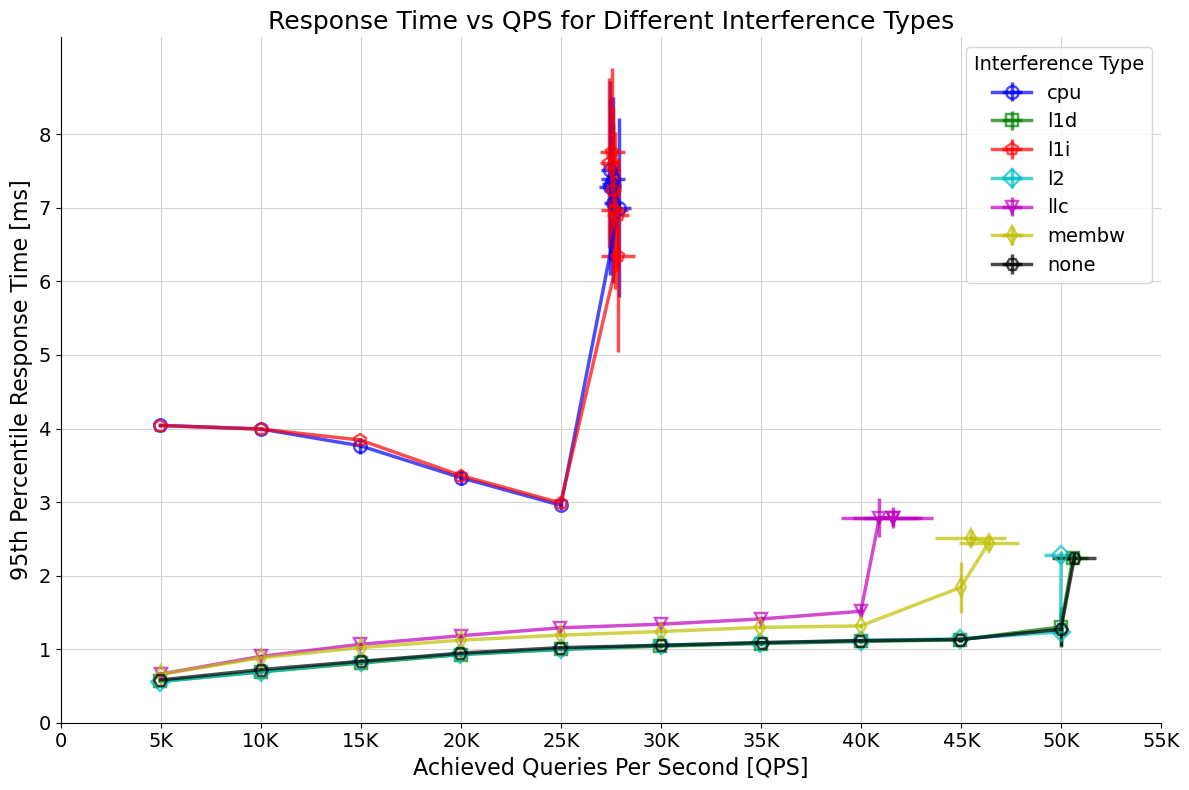

In [5]:
# Plot Style
# plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 8))
markers = ['o', 's', 'p', 'D', 'v', 'd', 'H']
default_color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Switch some colors for better plotting
default_color_cycle[1], default_color_cycle[2] = default_color_cycle[2], default_color_cycle[1]
colors = [
    '#0000ff',  # blue
    '#007f00',  # green
    '#ff0000',  # red
    '#00bfbf',  # light blue
    '#bf00bf',  # pink
    '#bfbf00',  # ocra
    '#000000'   # black
]

for key in sorted(dfs.keys()):
    parts = key.split('_')
    interference_type = '_'.join(parts[:-1])
    run_number = parts[-1]
    
    if interference_type in grouped_dfs:
        grouped_dfs[interference_type].append(dfs[key])

for i, (interference_type, df_list) in enumerate(grouped_dfs.items()):
    p95_means = list()
    p95_stds = list()
    qps_means = list()
    qps_stds = list()
    
    target_qps_levels = df_list[0]['target'].values if df_list else []
    
    for target_qps in target_qps_levels:
        p95_values = [df[df['target'] == target_qps]['p95'].values[0] / 1000.0 for df in df_list]
        qps_values = [df[df['target'] == target_qps]['QPS'].values[0] / 1000.0 for df in df_list]
        
        p95_means.append(np.mean(p95_values))
        p95_stds.append(np.std(p95_values, ddof=1))
        qps_means.append(np.mean(qps_values))
        qps_stds.append(np.std(qps_values, ddof=1))
    
    ax.errorbar(qps_means, p95_means, xerr=qps_stds, yerr=p95_stds, marker=markers[i], linewidth=2.5, 
                alpha=0.7, markersize=9, color=colors[i], markeredgewidth=1.75, markerfacecolor='none', label=interference_type)

# Plot Style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('white')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14) 
ax.legend(title='Interference Type', fontsize=14, title_fontsize=14)
x_labels = ['0', '5K', '10K', '15K', '20K', '25K', '30K', '35K', '40K', '45K', '50K', '55K']
ax.set_xticks(range(0, 56, 5), x_labels)
y_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8']
ax.set_yticks(range(0, 9, 1), y_labels)
ax.grid(True, color='lightgray')
ax.set_xlabel('Achieved Queries Per Second [QPS]', fontsize=16)
ax.set_ylabel('95th Percentile Response Time [ms]', fontsize=16)
ax.set_title('Response Time vs QPS for Different Interference Types', fontsize=18)
fig.tight_layout()

if True:
    plt.show()
else:
    matplotlib.use("pgf")
    plt.rc("pgf", texsystem="pdflatex", rcfonts=False)
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        # Use LaTeX default serif font.
        "font.serif": [],
    })
    plt.savefig("plots/plot1_CCA_guidelines.pgf", bbox_inches="tight", backend='pgf')
    print('done')